<a href="https://colab.research.google.com/github/GauravSahani1417/GAN-Implementation/blob/master/Cats_and_Dogs_GAN_Implementaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os import listdir 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import LeakyReLU,Dropout
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
def load_images(directory,n):
  images=[]
  i=0
  for file in listdir(directory):
    filename=directory + file
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.asarray(image)
    images.append(image)
    i += 1
    if i >= n:
      break
  return np.asarray(images)    


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
images=load_images('/content/drive/My Drive/cats_and_dogs_filtered/train/dogs/',25)

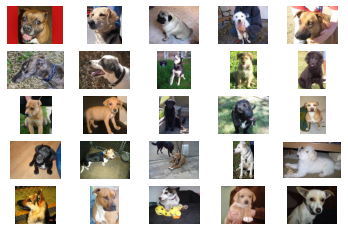

In [ ]:
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(images[i])
plt.show()  


In [ ]:
def define_D(in_shape=(128,128,3)):
  model=Sequential()
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
model_D=define_D()

In [ ]:
model_D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)       

In [ ]:
def define_G(latent_dim):
  model=Sequential()
  #foundation for 8*8 images
  n_nodes = 256 * 8 * 8
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 8, 256)))
  #UpSampling to 16*16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #UpSampling to 32*32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #UpSampling to 64*64
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #UpSampling to 128*128
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3, (7,7), activation='tanh', padding='same'))
  return model


In [ ]:
model_G=define_G(100)
model_G.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)      

In [ ]:
def define_GAN(model_G, model_D):
  model_D.trainable = False
  model = Sequential()
  model.add(model_G)
  model.add(model_D)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
model_gan = define_GAN(model_G, model_D)
model_gan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 128, 128, 3)       2984835   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 128961    
Total params: 3,113,796
Trainable params: 2,984,835
Non-trainable params: 128,961
_________________________________________________________________


In [ ]:
def load_real_images():
  datagen = ImageDataGenerator(rescale=1./255)
  X = datagen.flow_from_directory('/content/drive/My Drive/cats_and_dogs_filtered/train',
                                  target_size=(128,128),
                                  batch_size=12500,
                                  class_mode='binary')
  data_list = []
  batch_index = 0
  while batch_index <= X.batch_index:
    data = X.next()
    data_list.append(data[0])
    batch_index += 1
  img_array = np.asarray(data_list)
  return img_array  

In [ ]:
def generate_real_images(dataset, n_samples):
  i = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[i]
  y = np.ones((n_samples,1))
  return X,y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  X = np.random.randn(latent_dim * n_samples)
  X = X.reshape(n_samples, latent_dim)
  return X

In [ ]:
def generate_fake_images(model_G, latent_dim, n_samples):
  X_input = generate_latent_points(latent_dim, n_samples)
  X = model_G.predict(X_input)
  y = np.zeros((n_samples, 1))
  return X, y

In [ ]:
def summarize_performance(epoch, model_G, model_D, dataset, latent_dim, n_samples=100):
  model_G.save('/content/drive/My Drive/cats_and_dogs_filtered/model_dog_' +str(epoch)+ '.h5')
  X_real, y_real = generate_real_images(dataset, n_samples)
  _, acc_real = model_D.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_images(model_G, latent_dim, n_samples)
  _, acc_fake = model_D.evaluate(x_fake, y_fake, verbose=0)
  print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))


In [ ]:
def train_GAN(model_G, model_D, model_GAN, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  #manually enumerating epochs
  for i in range(n_epochs):
    # enumerate batches over training set
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_images(dataset, n_batch)
      X_fake, y_fake = generate_fake_images(model_G, latent_dim, n_batch)
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      d_loss, _ = model_D.train_on_batch(X, y)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = model_GAN.train_on_batch(X_gan, y_gan)
      #summerize the loss on this batch
      print('epoch: %d, batch:%d/%d, d_loss=%.3f, g_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performace, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, model_G, model_D, dataset, latent_dim)  


In [ ]:
latent_dim =100
model_D = define_D()
model_G = define_G(latent_dim)
model_GAN = define_GAN(model_G, model_D)
dataset=load_real_images()

Found 501 images belonging to 1 classes.


In [ ]:
train_GAN(model_G, model_D, model_GAN, dataset[0], latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 1, batch:1/3, d_loss=0.675, g_loss=0.693
epoch: 1, batch:2/3, d_loss=0.625, g_loss=0.692
epoch: 1, batch:3/3, d_loss=0.574, g_loss=0.689
epoch: 2, batch:1/3, d_loss=0.528, g_loss=0.682
epoch: 2, batch:2/3, d_loss=0.477, g_loss=0.661
epoch: 2, batch:3/3, d_loss=0.463, g_loss=0.604
epoch: 3, batch:1/3, d_loss=0.510, g_loss=0.493
epoch: 3, batch:2/3, d_loss=0.712, g_loss=0.375
epoch: 3, batch:3/3, d_loss=0.981, g_loss=0.307
epoch: 4, batch:1/3, d_loss=1.110, g_loss=0.341
epoch: 4, batch:2/3, d_loss=0.948, g_loss=0.488
epoch: 4, batch:3/3, d_loss=0.781, g_loss=0.656
epoch: 5, batch:1/3, d_loss=0.706, g_loss=0.832
epoch: 5, batch:2/3, d_loss=0.662, g_loss=1.002
epoch: 5, batch:3/3, d_loss=0.633, g_loss=1.170
epoch: 6, batch:1/3, d_loss=0.624, g_loss=1.296
epoch: 6, batch:2/3, d_loss=0.619, g_loss=1.336
epoch: 6, batch:3/3, d_loss=0.612, g_loss=1.379
epoch: 7, batch:1/3, d_loss=0.609, g_loss=1.355
epoch: 7, batch:2/3, d_loss=0.610, g_loss=1.332
epoch: 7, batch:3/3, d_loss=0.604, g_los

In [ ]:
model_G = load_model('/content/drive/My Drive/cats_and_dogs_filtered/model_dog_99.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
def plot_images(images, n):
  #scale image value in range of 0,1
  images = (images-images.min())/(images.max() - images.min())
  for i in range(n):
    plt.subplot(1, n, 1 + i)
    plt.axis('off')
    plt.imshow(images[i, :, :])
  plt.show()

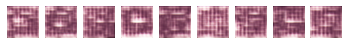

In [ ]:
pts = generate_latent_points(100,50)
X = model_G.predict(pts)
#Plotting the result
plot_images(X, 9)